### Mean Field theory of interacting fluids

:::{admonition} **What you need to know**
:class: note
- The van der Waals equation is the best known example of an equation of state that exhibits a
first-order phase transition with a critical end point.
- Since clearly the pressure remains a monotonic function of the volume in experiment, the van der Waals equation is amended by a Maxwell construction, in which the famous “equal area” cut of the van der Waals loop replaces that loop.

- This equal area construction is equivalent to replacing the corresponding van der Waals Helmholtz
free energy by its convex envelope.
:::

### Mean field approximation for a gas with interacting particles

- The canonical partition function splits into kinetic and potential energy contributions for a pure fluid. The kinetic energy part is the same as that of ideal gas. In the ideal gas, the last term is simply equal to volume. For nonideal gas, the last term can't be evaluated exactly in general, hence the need to make approximations. 

$$Z(\beta, N, V) = \frac{1}{N!h^{3N}}\int e^{-\beta\frac{p^2}{2m}}dp^N \cdot  \int e^{-\beta U(r)} dr^N$$

- When making mean-field approximation, we assume that each particle moves in some effective potential $U(r) = \sum_i U^i_{eff}(r)$ created by the rest of the particles. This allows us to use $Z=z^N$

$$Z(\beta, N, V) = \frac{1}{N!} \Bigg[\frac{(2\pi mk_B T)}{h^3} \Bigg]^N \cdot  \Bigg[ \int e^{-\beta U(r)} dr \Bigg]^N$$

### Van der Waals gas

- Van der Waals is a mean-field model for non-ideal gases. The essence of the model is in its two additions or modifications to the partition function: 
- First, each gas atom can occupy finite volume b; hence, the free volume with N particle in the container is $(V-bN)$
- Second, we write effective potential to be proportional to density; this is the essence of mean field approximation $U_{eff} = -a\frac{N}{V}$

$$Z(\beta, N, V) = \frac{1}{N!} \Bigg[\frac{(2\pi mk_B T)^{3/2}}{h^3} \Bigg]^N \cdot  \Bigg[(V-bn) e^{\frac{aN}{Vk_B T}} \Bigg]^N$$


- **Free energy at fixed volumes**
  
$$F = -k_BT logZ = -Nk_BT log \Bigg[\frac{(2\pi mk_B T)^{3/2}e}{h^3}\Big(\frac{V}{N}-b \Big) \Bigg] -\frac{aN^2}{V}$$

- **Free energy at fixed pressures**

$$G = F+pV$$

$$G = -Nk_BT log \Bigg[\frac{(2\pi mk_B T)^{3/2}e}{h^3}\Big(\frac{V}{N}-b \Big) \Bigg] -\frac{aN^2}{V} +pV$$

**Equation of state**

$$\frac{\partial G}{\partial V}=0$$

$$ \Big( p+\frac{aN^2}{V^2}\Big)(V-bN) = Nk_B T $$

### Reduced equation and correspondence state principle

- The critical point is the unique point where both derivatives of pressure vanish $dP/dV = d^2P/dV^2=0$. solving for the critical values of P, V and T we get:

$$V_c = 3Nb\,\,\,\, P_c =\frac{a}{27b^2}\,\,\,\,\,\, k_BT_c = \frac{8a}{27b}$$ 

- As we can see, different gases will have different critical points described by a and b parameters.
- But if you normalize pressure, temperature, and volume by their critical values, we get a reduced equation that describes many gases with a single curve!

- Taking $P_r = P/P_c$, $T_r = T/T_c$ and $V_r = V/V_c$ we get:

$$P_r = 8\frac{T_r}{(3 V_r-1)} - \frac{3}{(V_r^2)}$$


### Maxwell Construction

- Note that the area between liquid and gas shows unphysical dependence of pressure on volume
- The equilibrium pressure can be identified by making use of Gibbs free energy change around liquid and gas volumes $v_{liq}$ and $v_{gas}$. Taking a cyclic integral

$$\oint \frac{\partial G}{\partial P}dP = \oint VdP =0 $$

- In Maxwell, a construction line is drawn between the instability points in P vs V plot where the areas above and below it sum to one.
- On this straight line, we learn that the second-order derivative of free energy is zero.
- As a function of the extensive variable V, there is a region (between $v_{liq}$ and $v_{gas}$) of phase
coexistence. The densities of the extensive variables of the two phases in equilibrium are
discontinuous across the transition

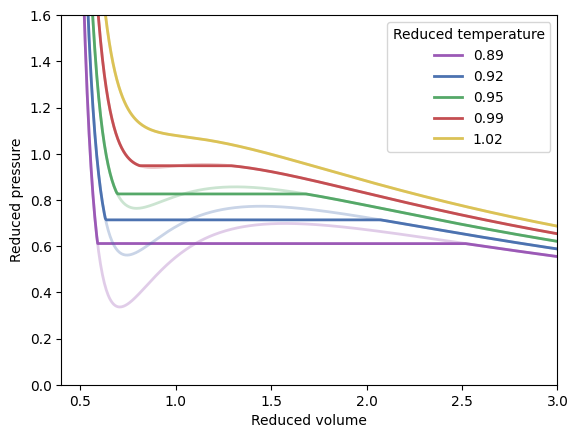

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import newton
from scipy.signal import argrelextrema

palette = iter(['#9b59b6', '#4c72b0', '#55a868', '#c44e52', '#dbc256'])

# Critical pressure, volume and temperature
# These values are for the van der Waals equation of state for CO2:
# (p - a/V^2)(V-b) = RT. Units: p is in Pa, Vc in m3/mol and T in K.
pc = 7.404e6
Vc = 1.28e-4
Tc = 304

def vdw(Tr, Vr):
    """Van der Waals equation of state.

    Return the reduced pressure from the reduced temperature and volume.

    """

    pr = 8*Tr/(3*Vr-1) - 3/Vr**2
    return pr


def vdw_maxwell(Tr, Vr):
    """Van der Waals equation of state with Maxwell construction.

    Return the reduced pressure from the reduced temperature and volume,
    applying the Maxwell construction correction to the unphysical region
    if necessary.

    """

    pr = vdw(Tr, Vr)
    if Tr >= 1:
        # No unphysical region above the critical temperature.
        return pr

    if min(pr) < 0:
         raise ValueError('Negative pressure results from van der Waals'
                         ' equation of state with Tr = {} K.'.format(Tr))

    # Initial guess for the position of the Maxwell construction line:
    # the volume corresponding to the mean pressure between the minimum and
    # maximum in reduced pressure, pr.
    iprmin = argrelextrema(pr, np.less)
    iprmax = argrelextrema(pr, np.greater)
    Vr0 = np.mean([Vr[iprmin], Vr[iprmax]])

    def get_Vlims(pr0):
        """Solve the inverted van der Waals equation for reduced volume.

        Return the lowest and highest reduced volumes such that the reduced
        pressure is pr0. It only makes sense to call this function for
        T<Tc, ie below the critical temperature where there are three roots.

        """

        eos = np.poly1d( (3*pr0, -(pr0+8*Tr), 9, -3) )
        roots = eos.r
        roots.sort()
        Vrmin, _, Vrmax = roots
        return Vrmin, Vrmax

    def get_area_difference(Vr0):
        """Return the difference in areas of the van der Waals loops.

        Return the difference between the areas of the loops from Vr0 to Vrmax
        and from Vrmin to Vr0 where the reduced pressure from the van der Waals
        equation is the same at Vrmin, Vr0 and Vrmax. This difference is zero
        when the straight line joining Vrmin and Vrmax at pr0 is the Maxwell
        construction.

        """

        pr0 = vdw(Tr, Vr0)
        Vrmin, Vrmax = get_Vlims(pr0)
        return quad(lambda vr: vdw(Tr, vr) - pr0, Vrmin, Vrmax)[0]

    # Root finding by Newton's method determines Vr0 corresponding to
    # equal loop areas for the Maxwell construction.
    Vr0 = newton(get_area_difference, Vr0)
    pr0 = vdw(Tr, Vr0)
    Vrmin, Vrmax = get_Vlims(pr0)

    # Set the pressure in the Maxwell construction region to constant pr0.
    pr[(Vr >= Vrmin) & (Vr <= Vrmax)] = pr0
    return pr

Vr = np.linspace(0.5, 3, 500)

def plot_pV(T):
    Tr = T / Tc
    c = next(palette)
    ax.plot(Vr, vdw(Tr, Vr), lw=2, alpha=0.3, color=c)
    ax.plot(Vr, vdw_maxwell(Tr, Vr), lw=2, color=c, label='{:.2f}'.format(Tr))

fig, ax = plt.subplots()

for T in range(270, 320, 10):
    plot_pV(T)

ax.set_xlim(0.4, 3)
ax.set_xlabel('Reduced volume')
ax.set_ylim(0, 1.6)
ax.set_ylabel('Reduced pressure')
ax.legend(title='Reduced temperature')

plt.show()

### Problems


1. Using van der Waals gas with $a=1$, $b=1$, $m=1$, and $N=1$ and adopting simplified units where $k_B=1$, $h=1$ plot dimensionless free energy per particle $G/Nk_BT$ vs. molar volume $V/N$ for temperatures 0.2, 0.22, 0.24, 0.26 and 0.28.
2. Minima on free energy correspond to equilibrium molar fractions of gas and liquid $v_{gas}$ and $v_{liq}$. For each of the temperatures in point 1, extract these molar volumes and then plot them on the same graph as a function of temperature $v_{gas}(T)$ and $v_{liq}(T)$
3. Using van der Waals equation of state, make a 3D plot of volume vs pressure vs temperature.
4. Find the critical volume, temperature, and pressure of Van der Waals gas $V_c, P_c, T_c$  by taking the first three derivatives of Gibbs free energy and setting it to zero, e.g  $\frac{\partial^n G}{\partial v^n}=$ (n=1,2,3)